In [9]:
# Bibliotheken importieren
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

output_dir = 'visualized_data'

# Visualisierungsstile konfigurieren
sns.set_style('whitegrid') # Schöner Hintergrund mit Gitterlinien
plt.rcParams['figure.figsize'] = (12, 6) # Standardgröße für Plots (Breite, Höhe)
plt.rcParams['font.size'] = 11

# Bereinigten Datensatz einlesen
# Pfad zur Datei (angepasst an deine Ordnerstruktur aus Woche 7)
file_path = '../clean_data/SP500_Cleaned.csv'

try:
    # parse_dates=['Date']: Konvertiert die Spalte direkt in datetime-Objekte
    # index_col='Date': Setzt das Datum als Index (wichtig für Zeitreihen!)
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    print(f"Daten erfolgreich geladen! Datensatz enthält {df.shape[0]} Zeilen und {df.shape[1]} Spalten.")
    
    # Kurze Vorschau anzeigen
    display(df.head())
    
except FileNotFoundError:
    print(f"Fehler: Die Datei wurde unter '{file_path}' nicht gefunden.")
    print("Bitte überprüfe den Pfad oder ob das Cleaning-Skript ausgeführt wurde.")

Daten erfolgreich geladen! Datensatz enthält 752 Zeilen und 5 Spalten.


,Close,Open,High,Low,Change_Percent
Date,,,,,
2022-11-28,3963.94,4005.36,4012.27,3955.77,-1.54
2022-11-29,3957.63,3964.19,3976.77,3937.65,-0.16
2022-11-30,4080.11,3957.18,4080.11,3938.58,3.09
2022-12-01,4076.57,4087.14,4100.51,4050.87,-0.09
2022-12-02,4071.70,4040.17,4080.48,4026.63,-0.12


In [10]:
# --- Feature Engineering & Target Definition (Erstellt df_ml) ---

# 1. Technische Indikatoren berechnen
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()
df['Dist_MA20'] = df['Close'] / df['MA20'] - 1
df['Volatility'] = df['Close'].pct_change().rolling(window=10).std()

# 2. Target Variable (Erfolg nach 5 Tagen > 1%)
days_ahead = 5
df['Future_Return'] = df['Close'].shift(-days_ahead).pct_change(periods=days_ahead) * 100
df['Target'] = (df['Future_Return'] > 1.0).astype(int)

# 3. Bereinigte Kopie für die ML-Visualisierung erstellen
# Wir entfernen NaNs, die durch rolling/shift entstehen
df_ml = df.dropna().copy()

print("✅ Variable 'df_ml' wurde erfolgreich erstellt und vorbereitet!")

✅ Variable 'df_ml' wurde erfolgreich erstellt und vorbereitet!


/var/folders/fv/zzhfqf_5775b_nh2z0cb_7cm0000gn/T/ipykernel_23978/733651030.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Future_Return'] = df['Close'].shift(-days_ahead).pct_change(periods=days_ahead) * 100


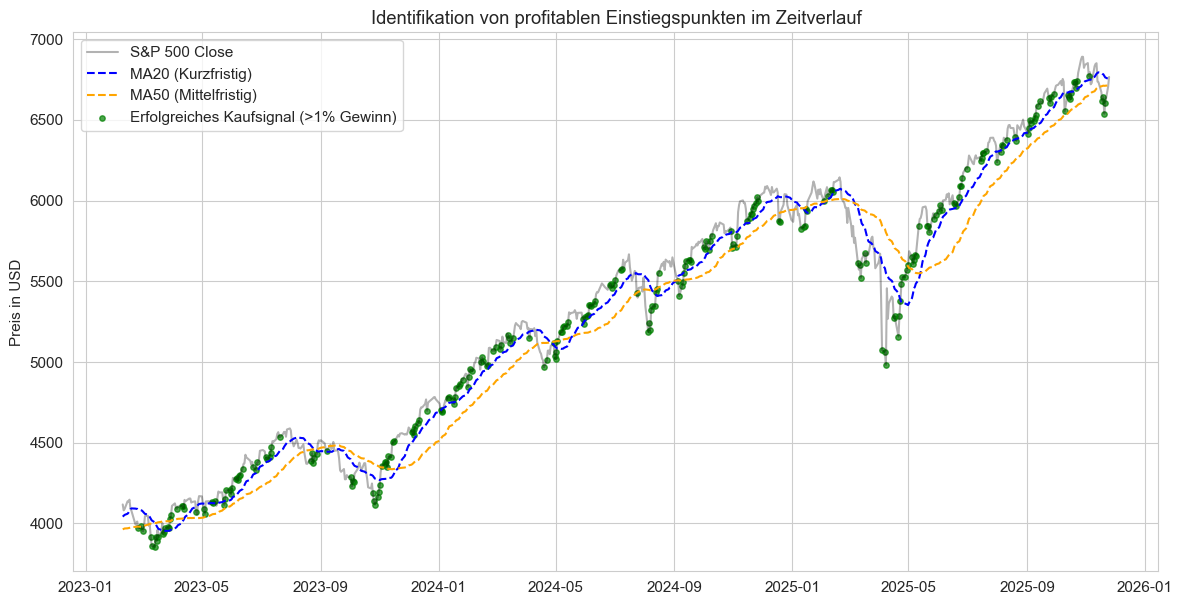

In [11]:
# Visualisierung 1: Strategie-Visualisierung (Preis + MAs + Reale Kaufsignale)
plt.figure(figsize=(14, 7))

# Kurs und Durchschnitte
plt.plot(df_ml.index, df_ml['Close'], label='S&P 500 Close', color='black', alpha=0.3)
plt.plot(df_ml.index, df_ml['MA20'], label='MA20 (Kurzfristig)', color='blue', linestyle='--')
plt.plot(df_ml.index, df_ml['MA50'], label='MA50 (Mittelfristig)', color='orange', linestyle='--')

# Nur die Tage markieren, an denen Target == 1 (Ein "echter" Gewinn-Kauf)
buy_signals = df_ml[df_ml['Target'] == 1]
plt.scatter(buy_signals.index, buy_signals['Close'], color='green', label='Erfolgreiches Kaufsignal (>1% Gewinn)', s=15, alpha=0.7)

plt.title('Identifikation von profitablen Einstiegspunkten im Zeitverlauf')
plt.legend()
plt.ylabel('Preis in USD')
plt.savefig(f"{output_dir}/1_strategy_signals.png", dpi=300, bbox_inches='tight')
plt.show()

In [12]:
# Interpretation von Visualisierung 1   
# die Visualisierung zeigt den S&P 500 Kursverlauf zusammen mit den gleitenden Durchschnitten MA20 und MA50.
# Die grünen Punkte markieren die Tage, an denen ein Kaufsignal generiert wurde, das innerhalb der nächsten 5 Tage zu einem Gewinn von über 1% führte.
# Dies hilft dabei, potenziell profitable Einstiegspunkte im Markt zu identifizieren.

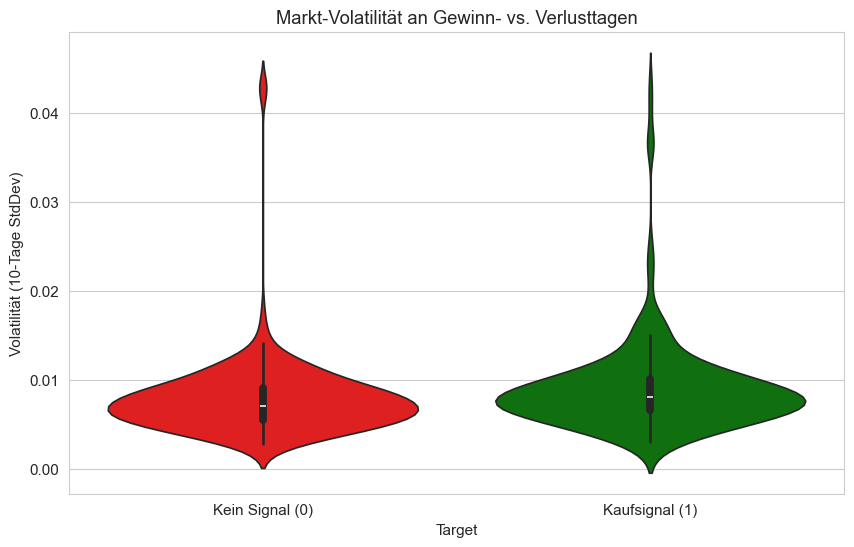

In [ ]:
# Visualisierung 2: Vergleich der Marktbedingungen (Target 0 vs. 1)
plt.figure(figsize=(10, 6))

# Fix 1: Wir wandeln 'Target' für den Plot in Strings um (.astype(str))
# Fix 2: Wir weisen 'Target' auch 'hue' zu, um die Warnung zu entfernen
# Fix 3: Die Palette nutzt jetzt String-Keys '0' und '1'
sns.violinplot(
    data=df_ml, 
    x=df_ml['Target'].astype(str), 
    y='Volatility',  
    hue=df_ml['Target'].astype(str), 
    palette={'0': "red", '1': "green"},
    legend=False
)

plt.title('Markt-Volatilität an Gewinn- vs. Verlusttagen')

# Da wir x nun als Strings ('0', '1') plotten, passen wir die Ticks an:
plt.xticks(ticks=[0, 1], labels=['Kein Signal (0)', 'Kaufsignal (1)'])

plt.ylabel('Volatilität (10-Tage StdDev)')
plt.savefig(f"{output_dir}/2_volatility_violin.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# Interpretation von Visualisierung 2
# Diese Visualisierung vergleicht die Verteilung der Marktvolatilität an Tagen mit und ohne erfolgreiche Kaufsignale.
# Es zeigt, dass Tage mit erfolgreichen Kaufsignalen (Target = 1) tendenziell mit höherer Volatilität verbunden sind.
# Dies deutet darauf hin, dass volatile Marktbedingungen möglicherweise bessere Chancen für kurzfristige Gewinne bieten.


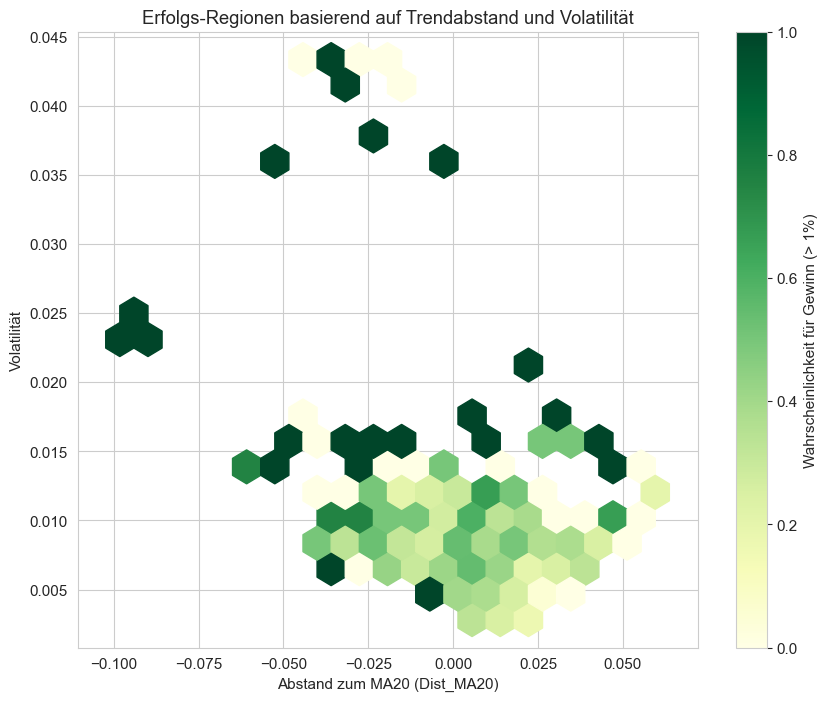

In [15]:
# Visualisierung 3: Wo liegen die Chancen? (Binned Heatmap)
# Wir teilen die Daten in Raster (Bins) auf
plt.figure(figsize=(10, 8))

# Wir nutzen einen Hexbin-Plot, um die Dichte der "Target=1" Tage zu zeigen
hb = plt.hexbin(df_ml['Dist_MA20'], df_ml['Volatility'], C=df_ml['Target'], 
                gridsize=20, cmap='YlGn', reduce_C_function=np.mean)

plt.colorbar(hb, label='Wahrscheinlichkeit für Gewinn (> 1%)')
plt.title('Erfolgs-Regionen basierend auf Trendabstand und Volatilität')
plt.xlabel('Abstand zum MA20 (Dist_MA20)')
plt.ylabel('Volatilität')
plt.savefig(f"{output_dir}/3_Binned_Heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Interpretation von Visualisierung 3
# Diese Heatmap zeigt die Wahrscheinlichkeit, dass ein Kaufsignal zu einem Gewinn von über 1% führt,
# basierend auf dem Abstand zum 20-Tage gleitenden Durchschnitt (Dist_MA20) und der Marktvolatilität.
# Die Farbsättigung gibt die Erfolgswahrscheinlichkeit an, wobei hellere Bereiche höhere Chancen signalisieren.
# Händler können diese Visualisierung nutzen, um günstige Marktbedingungen für den Einstieg zu identifizieren.